# Load Trained Models

## Import the Model Structure and parameters

In [30]:
import import_ipynb
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

In [14]:
# Model
# input_size = (30 * 3) * 33
# mid_size = 128 * 1
# output_size = 200 * 120

class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=(3, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 90 * 33 * 1
            # Out = 30 * 31 * 32
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 30 * 31 * 32
            # Out = 26 * 27 * 64
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 26 * 27 * 64
            # Out = 22 * 23 * 32
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 22 * 23 * 32
            # Out = 18 * 19 * 1
        )

        self.layerfc = nn.Sequential(
            nn.Linear(18*19, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 32)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # size_x = batch_size * 18 * 19
        # x = self.dropout(x)
        # x = self.layerfc(x)
        return x


class MyEncodeLSTM(nn.Module):
    def __init__(self):
        super(MyEncodeLSTM, self).__init__()

        self.hidden_size = 128
        self.num_layers = 2

        self.layer = nn.LSTM(36, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out[:, None, -1, :]  


class MyEncoder(nn.Module):
    def __init__(self):
        super(MyEncoder, self).__init__()

        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()
        self.lstm = MyEncodeLSTM()

    def forward(self, x):
        x = torch.chunk(x, 2, dim=0)
        x1 = self.cnn1.forward(x[0].view(-1, 1, 90, 33))
        x2 = self.cnn2.forward(x[1].view(-1, 1, 90, 33))

        # size_x = batch_size * 18 * 19

        x = torch.cat([x1, x2], dim=2).transpose(1, 2).view(-1, 19, 36)
        # size_x = batch_size * 36  * 19

        x = self.lstm.forward(x)
        return x


class MyDecodeLSTM(nn.Module):
    def __init__(self):
        super(MyDecodeLSTM, self).__init__()

        self.hidden_size = 64
        self.num_layers = 2
        self.hidden = self.init_hidden()

        self.layer = nn.LSTM(128, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def init_hidden(self):
        # Only for initialization
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out[:, -1, :]


class MyDecodeCNN(nn.Module):
    def __init__(self):
        super(MyDecodeCNN, self).__init__()

        self.layerfc = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1344)
        )

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 32, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 28 * 48 * 1
            # Out = 58 * 98 * 32
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 58 * 98 * 32
            # Out = 116 * 196 * 64
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 116 * 196 * 64
            # Out = 120 * 200 * 32
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(inplace=True),
            # No Unpooling
            # Upsample size by 2x2
            # In = 118 * 198 * 32
            # Out = 120 * 200 * 1
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layerfc(x)
        x = self.dropout(x)
        x = self.layer1(x.view(-1, 1, 28, 48))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # size_x = batch_size * 200 * 120

        return x


class MyDecoder(nn.Module):
    def __init__(self):
        super(MyDecoder, self).__init__()

        self.lstm = MyDecodeLSTM()
        self.cnn = MyDecodeCNN()

    def forward(self, x):
        x = self.lstm.forward(x)

        # size_x = batch_size * 375, need batch_size * 25 * 15

        x = self.cnn.forward(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncoder()
        self.decoder = MyDecoder()

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z) 
        return y

In [67]:
model = MyModel()

model.load_state_dict(torch.load('../Models/v0_special.pth'))
model.cuda()
model.eval()

MyModel(
  (encoder): MyEncoder(
    (cnn1): MyEncodeCNN(
      (layer1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (layer3): Sequential(
        (0): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (layer4): Sequential(
        (0): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2)

In [68]:
%matplotlib inline 
datadir = '../Dataset/make00/'
gt_x = datadir + 'x.npy'
gt_y = datadir + 'y.npy'

(2, 90, 33)


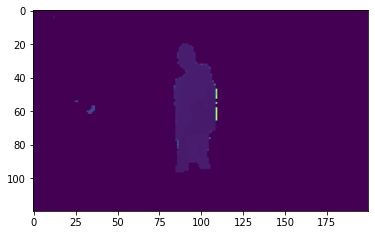

In [69]:
sample_x = np.load(gt_x)[3000]
sample_y = np.load(gt_y)[3000]
print(sample_x.shape)
plt.imshow(sample_y)
plt.show()

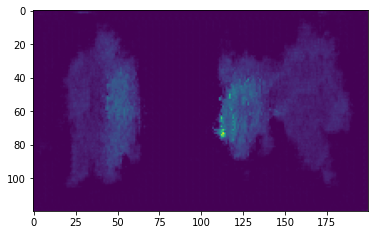

In [70]:
data = torch.tensor(sample_x, dtype=torch.float32, device='cuda')
predictions = model(data)
pred = predictions.cpu().detach().numpy()[0, 0]
plt.clf()
plt.plot(pred)
plt.show()